In [1]:
from training_utils import *
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

/home/hugo/projects/player_stats_predictor/footenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/player_stats_with_rolling_avgs.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84096 entries, 0 to 84095
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player                     84096 non-null  object 
 1   player_number              84096 non-null  float64
 2   nation                     84096 non-null  object 
 3   pos                        84096 non-null  object 
 4   age                        84096 non-null  object 
 5   min                        84096 non-null  int64  
 6   gls                        84096 non-null  int64  
 7   ast                        84096 non-null  int64  
 8   pk                         84096 non-null  int64  
 9   pkatt                      84096 non-null  int64  
 10  sh                         84096 non-null  int64  
 11  sot                        84096 non-null  int64  
 12  crdy                       84096 non-null  int64  
 13  crdr                       84096 non-null  int

## Model 1 : Predict Win Draw Loss

In [4]:
df = pd.read_csv('data/player_stats_with_rolling_avgs.csv')


class_targets = ['Result']

# Process and Train
X, Y = prepare_match_data(df, POSITIONS, class_targets)


In [5]:
from sklearn.utils.class_weight import compute_sample_weight

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# 6. Model Training
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

Overall Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

     Win (A)       1.00      1.00      1.00       210
        Draw       1.00      1.00      1.00       149
     Win (B)       1.00      1.00      1.00       209

    accuracy                           1.00       568
   macro avg       1.00      1.00      1.00       568
weighted avg       1.00      1.00      1.00       568



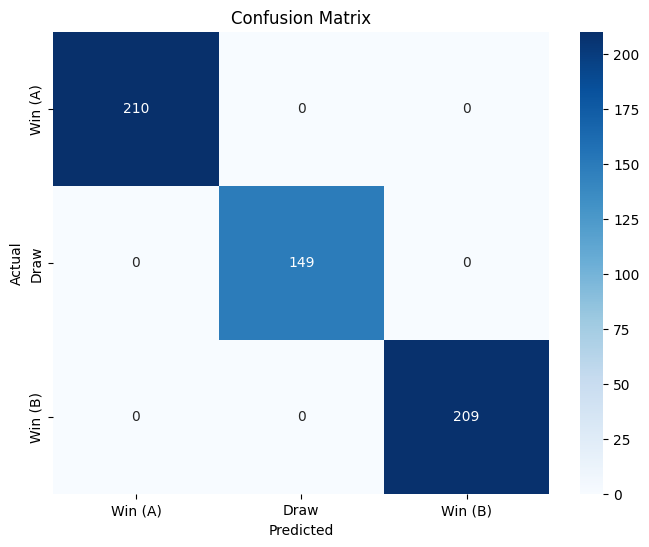

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Predictions
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test) # Get percentages

print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Win (A)', 'Draw', 'Win (B)']))

# Visualizing the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Win (A)', 'Draw', 'Win (B)'], 
            yticklabels=['Win (A)', 'Draw', 'Win (B)'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model 2 : Predict the number of goals

In [7]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

reg_targets = ['TeamA_Goals_Scored', 'TeamB_Goals_Scored']

X, Y= prepare_match_data(df, POSITIONS, reg_targets)

# --- 3. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# --- 4. Define and Train the Multi-Output Model ---
# Using Poisson objective because goals are count data (0, 1, 2...)
base_model = XGBRegressor(
    objective='count:poisson', 
    n_estimators=100, 
    learning_rate=0.08, 
    max_depth=4
)

multi_model = MultiOutputRegressor(base_model)
multi_model.fit(X_train, y_train)

print("Model training complete for Team A and Team B goals.")

Model training complete for Team A and Team B goals.


In [8]:
# Generate raw goal predictions (floats)
raw_preds = multi_model.predict(X_test)

# Convert to a readable DataFrame
results = pd.DataFrame(raw_preds, columns=['Pred_TeamA_Goals', 'Pred_TeamB_Goals'])

# Round to get the "Expected Score"
results['Score_A'] = np.round(results['Pred_TeamA_Goals']).astype(int)
results['Score_B'] = np.round(results['Pred_TeamB_Goals']).astype(int)

# Compare with Actuals
results['Actual_A'] = y_test['TeamA_Goals_Scored'].values
results['Actual_B'] = y_test['TeamB_Goals_Scored'].values

print(results.head(10))

   Pred_TeamA_Goals  Pred_TeamB_Goals  Score_A  Score_B  Actual_A  Actual_B
0          1.167945          1.735218        1        2         1         3
1          1.815068          1.377991        2        1         1         1
2          2.196249          1.335200        2        1         1         1
3          1.381099          0.909258        1        1         2         1
4          1.138948          1.315374        1        1         1         2
5          1.571720          0.879224        2        1         0         2
6          1.273610          1.515363        1        2         0         0
7          1.276633          1.497784        1        1         0         1
8          2.058151          2.223453        2        2         0         4
9          1.300882          1.162379        1        1         2         1


In [9]:
from sklearn.metrics import mean_absolute_error

mae_a = mean_absolute_error(results['Actual_A'], results['Pred_TeamA_Goals'])
mae_b = mean_absolute_error(results['Actual_B'], results['Pred_TeamB_Goals'])

print(f"Average error for Team A goals: {mae_a:.2f}")
print(f"Average error for Team B goals: {mae_b:.2f}")

Average error for Team A goals: 0.98
Average error for Team B goals: 0.96


In [10]:
def get_result(row):
    if row['Score_A'] > row['Score_B']: return 'Win A'
    if row['Score_A'] < row['Score_B']: return 'Win B'
    return 'Draw'

results['Derived_Result'] = results.apply(get_result, axis=1)

### Precision/Recall Report (Derived from Goal Predictions) ###
              precision    recall  f1-score   support

     Win (A)       0.48      0.40      0.44       210
        Draw       0.27      0.49      0.35       149
     Win (B)       0.51      0.30      0.38       209

    accuracy                           0.39       568
   macro avg       0.42      0.40      0.39       568
weighted avg       0.44      0.39      0.39       568



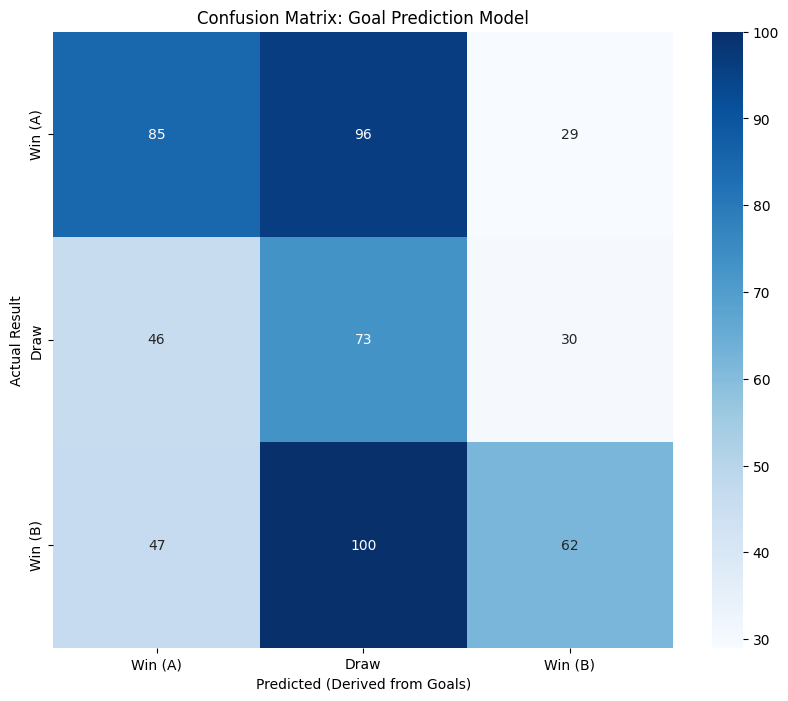

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Run the prediction (This defines 'preds')
# It will be a 2D array: [[TeamA_Goals, TeamB_Goals], ...]
preds = multi_model.predict(X_test)

# 2. Function to convert goals into Win/Draw/Loss labels
def get_label_from_goals(team_a_goals, team_b_goals):
    # We round because goals must be whole numbers
    rounded_a = np.round(team_a_goals)
    rounded_b = np.round(team_b_goals)
    
    if rounded_a > rounded_b:
        return 0  # Win A
    elif rounded_a == rounded_b:
        return 1  # Draw
    else:
        return 2  # Win B

# 3. Apply the logic to your predictions
y_pred_derived = [get_label_from_goals(p[0], p[1]) for p in preds]

# 4. Apply the logic to the actual results (y_test)
y_test_derived = [get_label_from_goals(row[0], row[1]) for row in y_test.values]

# 5. Print the Report
target_names = ['Win (A)', 'Draw', 'Win (B)']
print("### Precision/Recall Report (Derived from Goal Predictions) ###")
print(classification_report(y_test_derived, y_pred_derived, target_names=target_names))

cm = confusion_matrix(y_test_derived, y_pred_derived)

# 2. Create the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    xticklabels=['Win (A)', 'Draw', 'Win (B)'], 
    yticklabels=['Win (A)', 'Draw', 'Win (B)'], 
    cmap='Blues'
)

plt.xlabel('Predicted (Derived from Goals)')
plt.ylabel('Actual Result')
plt.title('Confusion Matrix: Goal Prediction Model')
plt.show()

In [12]:
from sklearn.metrics import precision_score

# Calculate precision for each class separately
precision_scores = precision_score(y_test_derived, y_pred_derived, average=None)

print(f"Precision for Win (A): {precision_scores[0]:.2%}")
print(f"Precision for Draw:    {precision_scores[1]:.2%}")
print(f"Precision for Win (B): {precision_scores[2]:.2%}")

# Overall weighted precision
total_precision = precision_score(y_test_derived, y_pred_derived, average='weighted')
print(f"\nOverall Weighted Precision: {total_precision:.2%}")

Precision for Win (A): 47.75%
Precision for Draw:    27.14%
Precision for Win (B): 51.24%

Overall Weighted Precision: 43.63%


In [13]:
# Prepare your metrics dictionary
model_metrics = {
    "weighted_precision": total_precision, # From the code we ran earlier
    "accuracy": accuracy_score(y_test_derived, y_pred_derived),
    "mae_team_a": mae_a,
    "mae_team_b": mae_b
}

# Upload
if False:
    upload_model_to_hopsworks(
        model=multi_model,
        X_train=X_train,
        y_train=y_train,
        metrics=model_metrics,
        project_name='player_stat_prediction',
        model_name="xgboost_goals_2teams"
    )

In [14]:
print(len(list(X.columns)))

240
